# Solution path for the `Wine Quality` data set

The data set can be downloaded from <http://archive.ics.uci.edu/ml/datasets/Wine+Quality>.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer

sys.path.append('../..')
from modules import full_path, path_solver, dual_sorted_L1_norm as dual_norm, pattern, full_path_LASSO, min_SURE, min_SURE_LASSO

In [2]:
# Import of the data set
wine = pd.read_csv('../datasets/winequality-red.csv', sep=';')
data = wine.drop(columns=['quality'])
target = wine['quality']

In [3]:
# Setting (and data standardization)
X = data.to_numpy(dtype=float)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0, ddof=0)
X = (X - X_mean) / X_std

y = target.to_numpy(dtype=float)
y_mean = y.mean()
y = y - y_mean

# Lambda = np.linspace(4,1,X.shape[-1],dtype=float)
Lambda = np.sqrt(range(1,12))-np.sqrt(range(0,11))

In [4]:
# Numba compilation
_ = full_path(X, y , Lambda, ratio=0., k_max=0., rtol_pattern=1e-6, atol_pattern = 1e-6, rtol_gamma=1e-6, split_max=1e1, log=0)
_ = path_solver(X, y, Lambda, k_max=0., rtol_pattern=1e-6, atol_pattern = 1e-6, rtol_gamma=1e-6, split_max=1e1, log=0)
_ = full_path_LASSO(X, y, ratio=0., k_max=0., rtol_sign=1e-6, atol_sign = 1e-6, rtol_gamma=1e-6, split_max=1e1, log=0)

## SLOPE

### Full path

In [5]:
# Full SLOPE path
Gamma, Sol, Primal, Gap, M, Split, T = full_path(X, y , Lambda, ratio=1., k_max=1e4, rtol_pattern=1e-10, atol_pattern = 1e-10, rtol_gamma=1e-10, split_max=1e1, log=1)

node 0: gamma = 898.291, elapsed time = 7.34e-05s, gap = 0.00e+00
node 1: gamma = 850.633, elapsed time = 2.81e-03s, gap = 4.55e-13
node 2: gamma = 834.176, elapsed time = 3.88e-03s, gap = 4.55e-13
node 3: gamma = 518.014, elapsed time = 4.14e-03s, gap = 3.98e-13
node 4: gamma = 503.663, elapsed time = 4.37e-03s, gap = 3.98e-13
node 5: gamma = 490.715, elapsed time = 4.65e-03s, gap = 5.12e-13
node 6: gamma = 393.072, elapsed time = 4.85e-03s, gap = 6.25e-13
node 7: gamma = 342.330, elapsed time = 5.11e-03s, gap = 7.39e-13
node 8: gamma = 331.802, elapsed time = 5.30e-03s, gap = 8.53e-13
node 9: gamma = 321.273, elapsed time = 5.52e-03s, gap = 7.96e-13
node 10: gamma = 269.699, elapsed time = 6.10e-03s, gap = 1.71e-13
node 11: gamma = 253.852, elapsed time = 6.38e-03s, gap = 8.53e-13
node 12: gamma = 241.336, elapsed time = 6.69e-03s, gap = 1.14e-13
node 13: gamma = 193.852, elapsed time = 7.02e-03s, gap = 2.27e-13
node 14: gamma = 184.583, elapsed time = 7.35e-03s, gap = 2.27e-13
node 

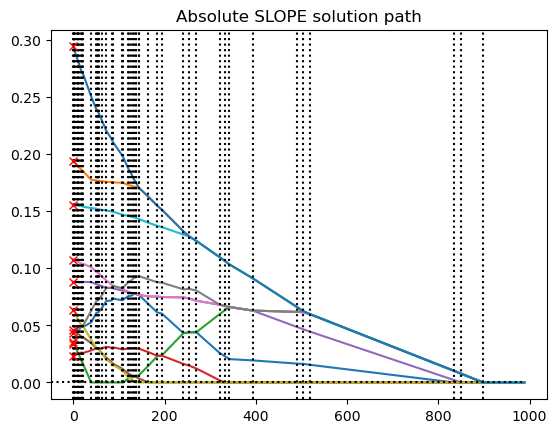

In [6]:
# Absolute SLOPE solution path + ols
abs_Sol = [np.abs(sol) for sol in Sol]

ols = np.linalg.solve(X.T@X, X.T@y)
abs_ols = np.abs(ols)
    
fig, ax = plt.subplots()
ax.plot([1.1*Gamma[0]] + Gamma, [Sol[0]] + abs_Sol)
for gamma in Gamma:
    ax.axvline(gamma, color='k', linestyle=':')
ax.axhline(0, color='k', linestyle=':', xmax=0.95)
ax.plot(0, [np.abs(ols)], 'rx')
# ax.set_xscale('symlog')
ax.set_title('Absolute SLOPE solution path')
plt.show() 

In [7]:
fig.savefig('../results/wine-quality_SLOPEpath', bbox_inches="tight", pad_inches=0.05)

### Solver

In [8]:
# SLOPE solver 
frac = 0.5; gamma = frac*dual_norm(X.T@y, Lambda)
t_start = timer()
sol, (primal, gap), k = path_solver(X, y , gamma*Lambda, k_max=1e3, rtol_pattern=1e-10, atol_pattern = 1e-10, rtol_gamma=1e-10, split_max=1e1, log=0)
print(f'pattern for {frac} x gamma_max: {pattern(sol, tol=1e-10)}')
print(f'elapsed time = {timer() - t_start:.2e}s, crossed nodes = {k}, primal-dual gap = {gap:.2e}')

pattern for 0.5 x gamma_max: [ 1 -4  3  0 -2  0 -3 -3  0  4  4]
elapsed time = 1.88e-03s, crossed nodes = 6, primal-dual gap = 8.53e-13


### SURE exact minimization

In [9]:
sigma2 = np.linalg.norm(y-X@ols,ord=2)**2/(X.shape[0]-X.shape[1])
Critical, SURE, Sol = min_SURE(X, y, Lambda, Gamma, M, sigma2, tol=1e-10)   
i0 = np.argmin(SURE)
print(f'SURE minimizer: gamma = {Critical[i0]:.3f}')
print(f'SURE minimum: sure(gamma) = {SURE[i0]:.3f}')     
print(f'solution in gamma: {Sol[i0]}')  
print(f'solution pattern in gamma: {pattern(Sol[i0],tol=1e-10)}')

SURE minimizer: gamma = 18.629
SURE minimum: sure(gamma) = 3.464
solution in gamma: [ 0.04990686 -0.18598742 -0.01842615  0.0261484  -0.0879266   0.04020234
 -0.10419991 -0.04990686 -0.04990686  0.15437017  0.2721147 ]
solution pattern in gamma: [ 4 -8 -1  2 -5  3 -6 -4 -4  7  9]


## LASSO

### Full path

In [10]:
# Full LASSO path
Gamma, Sol, S, Split, T = full_path_LASSO(X, y, ratio=1., k_max=1e4, rtol_sign=1e-10, atol_sign = 1e-10, rtol_gamma=1e-10, split_max=1e1, log=1)

node 0: gamma = 614.683, elapsed time = 1.19e-04s
node 1: gamma = 476.147, elapsed time = 3.14e-03s
node 2: gamma = 242.719, elapsed time = 4.47e-03s
node 3: gamma = 136.465, elapsed time = 4.69e-03s
node 4: gamma = 91.902, elapsed time = 4.87e-03s
node 5: gamma = 85.998, elapsed time = 5.12e-03s
node 6: gamma = 74.879, elapsed time = 5.62e-03s
node 7: gamma = 30.414, elapsed time = 5.98e-03s
node 8: gamma = 26.418, elapsed time = 6.43e-03s
node 9: gamma = 16.538, elapsed time = 6.79e-03s
node 10: gamma = 11.760, elapsed time = 1.21e-02s
node 11: gamma = 9.430, elapsed time = 1.73e-02s
node 12: gamma = 7.428, elapsed time = 2.76e-02s
node 13: gamma = 0.000, elapsed time = 3.25e-02s


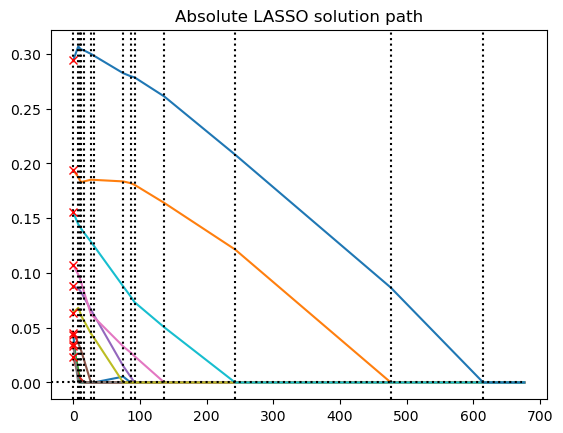

In [11]:
# Absolute LASSO solution path + ols
abs_Sol = [np.abs(sol) for sol in Sol]

ols = np.linalg.solve(X.T@X, X.T@y)
abs_ols = np.abs(ols)
    
fig, ax = plt.subplots()
ax.plot([1.1*Gamma[0]] + Gamma, [Sol[0]] + abs_Sol)
for gamma in Gamma:
    ax.axvline(gamma, color='k', linestyle=':')
ax.axhline(0, color='k', linestyle=':', xmax=0.95)
ax.plot(0, [np.abs(ols)], 'rx')
# ax.set_xscale('symlog')
ax.set_title('Absolute LASSO solution path')
plt.show() 

In [12]:
fig.savefig('../results/wine-quality_LASSOpath', bbox_inches="tight", pad_inches=0.05)

### SURE exact minimization

In [13]:
Critical, SURE, Sol = min_SURE_LASSO(X, y, Gamma, S, sigma2, tol=1e-10)
i0 = np.argmin(SURE)
print(f'SURE minimizer: gamma = {Critical[i0]:.3f}')
print(f'SURE minimum: sure(gamma) = {SURE[i0]:.3f}')
Sol[i0][np.abs(Sol[i0])<1e-10] = 0     
print(f'solution in gamma: {Sol[i0]}')  
print(f'solution sign in gamma: {np.sign(Sol[i0])}')

SURE minimizer: gamma = 11.760
SURE minimum: sure(gamma) = 4.130
solution in gamma: [ 0.         -0.18308103  0.          0.00305619 -0.08247961  0.02912847
 -0.09176088  0.         -0.06093142  0.14040801  0.30419793]
solution sign in gamma: [ 0. -1.  0.  1. -1.  1. -1.  0. -1.  1.  1.]


### Comparison between SLOPE and LASSO on simulated data

We simulate $y = X \hat \beta^{\text{ols}} + w$ with $w \sim \mathcal N(0,\sigma^2 Id_n)$.

In [14]:
sigma2 = np.linalg.norm(y-X@ols,ord=2)**2/(X.shape[0]-X.shape[1])

n_samples = 1000
sure_slope = []; err_slope = []; sure_lasso = []; err_lasso = []; err_ols = []

rng = np.random.default_rng(0)
for i in range(n_samples):
    # white noise
    w = rng.normal(0, np.sqrt(sigma2), X.shape[0])
    # SLOPE
    Gamma, Sol, Primal, Gap, M, Split, T = full_path(X, X@ols+w , Lambda, ratio=1., k_max=1e4, rtol_pattern=1e-10, atol_pattern = 1e-10, rtol_gamma=1e-10, split_max=1e1, log=0)
    Critical, SURE, Sol = min_SURE(X, X@ols+w, Lambda, Gamma, M, sigma2, tol=1e-10)
    i0 = np.argmin(SURE)
    sure_slope.append(SURE[i0])
    err_slope.append(np.linalg.norm(X@Sol[i0]-X@ols,ord=2)**2)
    # LASSO
    Gamma, Sol, S, Split, T = full_path_LASSO(X, X@ols+w, ratio=1., k_max=1e4, rtol_sign=1e-10, atol_sign = 1e-10, rtol_gamma=1e-10, split_max=1e1, log=0)
    Critical, SURE, Sol = min_SURE_LASSO(X, X@ols+w, Gamma, S, sigma2, tol=1e-10)
    i0 = np.argmin(SURE)
    sure_lasso.append(SURE[i0])
    err_lasso.append(np.linalg.norm(X@Sol[i0]-X@ols,ord=2)**2)
    # OLS
    sol = np.linalg.solve(X.T@X, X.T@(X@ols+w))
    err_ols.append(np.linalg.norm(X@sol-X@ols,ord=2)**2)

print(f'prediction error for SLOPE: {np.mean(err_slope):.3f}')
print(f'prediction error for LASSO: {np.mean(err_lasso):.3f}')
print(f'prediction error for OLS: {np.mean(err_ols):.3f}')

prediction error for SLOPE: 4.776
prediction error for LASSO: 4.927
prediction error for OLS: 4.710


#### SURE as an unbiased estimator of the prediction error

In [15]:
from modules.sure import SURE_SLOPE

In [18]:
gamma = 0.5*dual_norm(X.T@(X@ols), Lambda)
sigma2 = np.linalg.norm(y-X@ols,ord=2)**2/(X.shape[0]-X.shape[1])

n_samples = 1000
sure_slope = []; err_slope = []

rng = np.random.default_rng(0)
for i in range(n_samples):
    w = rng.normal(0, np.sqrt(sigma2), X.shape[0])
    sol, *_ = path_solver(X, X@ols+w , gamma*Lambda, k_max=1e3, rtol_pattern=1e-10, atol_pattern = 1e-10, rtol_gamma=1e-10, split_max=1e1, log=0)
    sure_slope.append(SURE_SLOPE(X, X@ols+w, sol, sigma2, tol=1e-10))
    err_slope.append(np.linalg.norm(X@sol - X@ols, ord=2)**2)
print(f'average SURE for SLOPE: {np.mean(sure_slope):.3f}')
print(f'prediction error for SLOPE: {np.mean(err_slope):.3f}')

average SURE for SLOPE: 120.379
prediction error for SLOPE: 120.249
